# 10 days FWI Reanalysis forecast using 4 days input

We will do 10 day FWI-Reanalysis forecast using 4-days input of Temperature, Relative humidity, Total precipitation, and Wind speed. The sample data must span for at least 13 consecutive days. The file format of the stored data should be in netCDF4 format. A pretrained model checkpoint conrresponding to the input and forecast timespan will be required as well.

#### Changing working directory to import modules naturally

In [18]:
import os
os.chdir('../src')
from train import str2num, get_hparams, get_model

#### Importing installed modules

In [19]:
# General functionality
import random
from glob import glob
from argparse import Namespace
import pickle
import tempfile

# Keep the execution uncomplicated
import warnings
warnings.filterwarnings('ignore')

# Ploting purposes
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Scientific computing
import numpy as np
import torch

# Helper modules
import pytorch_lightning as pl
from pytorch_lightning import Trainer

#### Ensuring reproducibility

In [20]:
SEED = 2334
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)
np.random.seed(SEED)
random.seed(SEED)

#### Creating pickled list of test-set files

In [21]:
# Only the files needed for output variable are specified.
# Input varaible files for corresponding dates are auto-deduced.
test_out_files = [f'/nvme0/fwi-reanalysis/ECMWF_FWI_201904{x:02}_1200_hr_fwi_e5.nc' for x in range(1, 14)]
print("First few files...", *test_out_files[:3], sep='\n')

# Pickling the list which can be used later
with tempfile.NamedTemporaryFile(delete=False) as tmp:
    pickle.dump(test_out_files, tmp)
    test_set_path = tmp.name

First few files...
/nvme0/fwi-reanalysis/ECMWF_FWI_20190401_1200_hr_fwi_e5.nc
/nvme0/fwi-reanalysis/ECMWF_FWI_20190402_1200_hr_fwi_e5.nc
/nvme0/fwi-reanalysis/ECMWF_FWI_20190403_1200_hr_fwi_e5.nc


#### Adjusting the knobs

In [22]:
# Storing hyperparamters and configuration in a dictionary
hparams_dict = get_hparams(
    # Feature density of U-Net layers
    init_features=16,
    # Number of input channels (=4*input days)
    in_days=4,
    # Number of prediction channels (=output days)
    out_days=10,
    # Loss metric
    loss='mse',
    # Batch size
    batch_size=1,
    # Number of GPUs to use
    gpus=1,
    # Turn on temporal and spatial constraints for case-study in Australia
    case_study=False,
    # Whether to ignore fire-prone regions
    clip_fwi=False,
    # Pickled list of output files in test-set
    test_set=test_set_path,
    # Model architecture
    model='unet_tapered',
    # Output dataloader
    out='fwi_reanalysis',
    # Directory with FWI Forcings input
    forcings_dir='/nvme1/fwi-forcings',
    # Directory with FWI Renanlysis output
    reanalysis_dir='/nvme0/fwi-reanalysis',
    # Custom mask stored as numpy array
    mask='dataloader/mask.npy',
    # Threshold used to calculate accuracy
    thresh=9.4,
    # Model checkpoint file used to load the pretrained weights
    checkpoint_file='/w/deepfwi/src/model/checkpoints/pre_trained/4_10/epoch_75_82.ckpt'
    )

# Converting the dictionary to Namespace for easier access
hparams = Namespace(**hparams_dict)

 |  init-features -> 16             
 |        in-days -> 4              
 |       out-days -> 10             
 |         epochs -> 100            
 |  learning-rate -> 0.001          
 |           loss -> mse            
 |     batch-size -> 1              
 |          split -> 0.2            
 |      use-16bit -> True           
 |           gpus -> 1              
 |          optim -> one_cycle      
 |        dry-run -> False          
 |     case-study -> False          
 |       clip-fwi -> False          
 |       test-set -> /tmp/tmpi7vr0nfq
 |          model -> unet_tapered   
 |            out -> fwi_reanalysis 
 |   forecast-dir -> /nvme0/wikilimo-remote-gpu-tpu/deepfwi/src
 |   forcings-dir -> /nvme1/fwi-forcings
 | reanalysis-dir -> /nvme0/fwi-reanalysis
 |           mask -> dataloader/mask.npy
 |         thresh -> 9.4            
 |        comment -> Unet tapered - residual
 |  save-test-set -> False          
 |checkpoint-file -> /w/deepfwi/src/model/checkpoints/pre_trai

#### Setting the flag for inference

In [23]:
hparams.eval = True

#### Preparing the model

In [24]:
# Create the model architecture and attach with the data
model = get_model(hparams)

# Load the pretrained weights
model.load_state_dict(torch.load(hparams.checkpoint_file)["state_dict"])

# Turn off the gradients
model.eval();

Start date: <xarray.DataArray 'time' ()>
array('2019-04-01T00:00:00.000000000', dtype='datetime64[ns]') 
End date: <xarray.DataArray 'time' ()>
array('2019-04-13T00:00:00.000000000', dtype='datetime64[ns]')


### Manual inference

In [25]:
# Input tensor
x = model.data[0][0].unsqueeze(0)

# Ground truth tensor
y = model.data[0][1].unsqueeze(0)

# Predicted tensor
y_hat = model(x).detach()

# Masking the prediction as done with the ground truth
y_hat[torch.isnan(y)] = torch.tensor(float('nan'))

#### Input variables

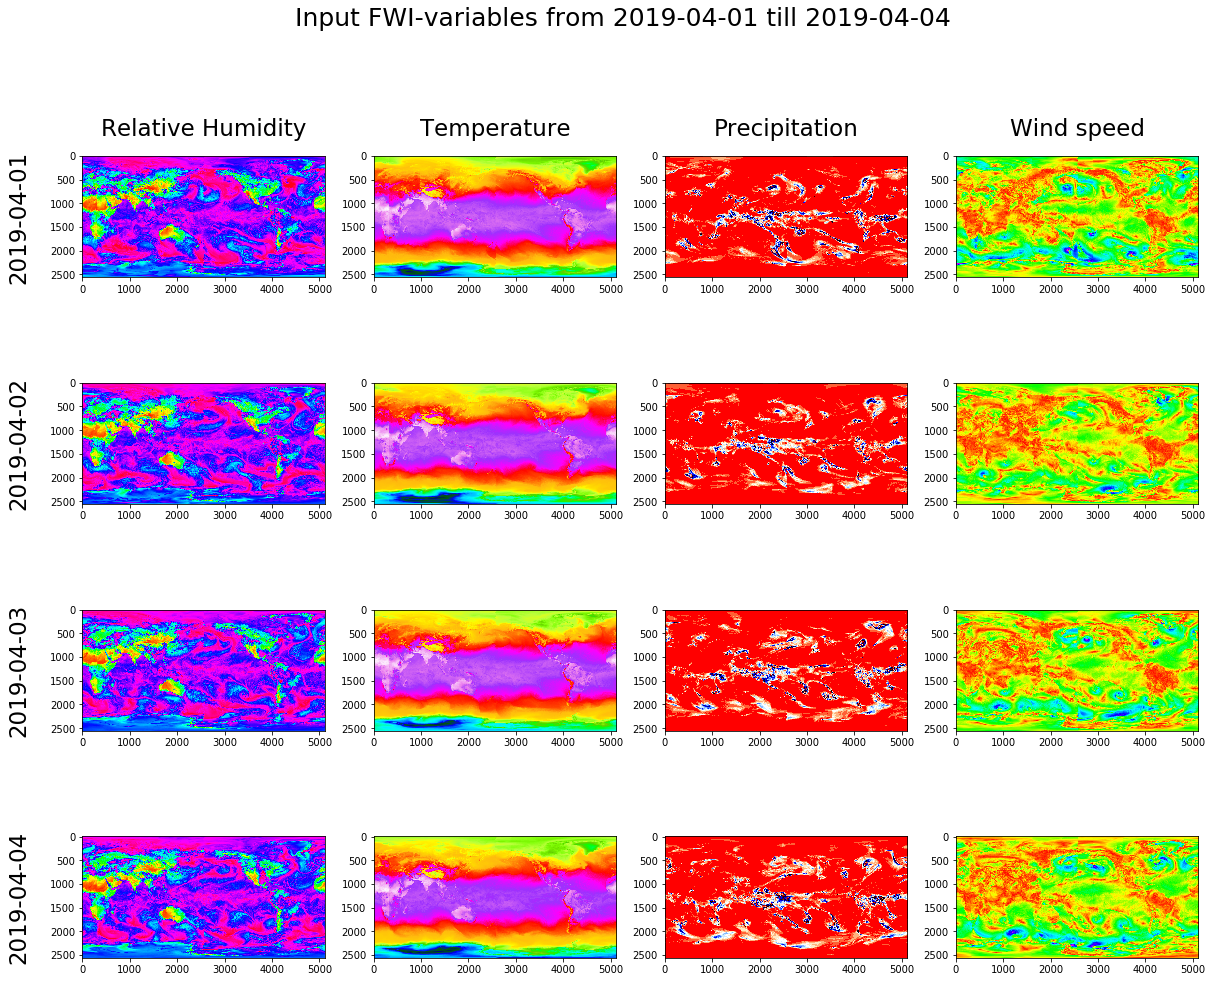

In [16]:
fig=plt.figure(figsize=(20, hparams.in_days*4))
fig.suptitle('Input FWI-variables from 2019-04-01 till 2019-04-04', fontsize=25)
for i in range(hparams.in_days):
    for j in range(4):
        ax = fig.add_subplot(hparams.in_days, 4, 4*i+j+1)
        if i==0:
            if j==0:
                ax.set_title('Relative Humidity',fontsize='23', pad=20)
            elif j==1:
                ax.set_title('Temperature',fontsize='23', pad=20)
            elif j==2:
                ax.set_title('Precipitation',fontsize='23', pad=20)
            else:
                ax.set_title('Wind speed',fontsize='23', pad=20)
        if j==0:
            ax.set_ylabel(f'2019-04-{i+1:02}', fontsize='23', labelpad=20)
        if j==1:
            plt.imshow(x.squeeze()[4*i+j], cmap='gist_ncar')
        elif j==2:
            plt.imshow(x.squeeze()[4*i+j], cmap='flag')
        else:
            plt.imshow(x.squeeze()[4*i+j], cmap='hsv')
plt.show()

*Helper function to add colorbar in the plots.*

In [26]:
def plot(im, title):
    fig, ax = plt.subplots(figsize = (20,10))
    fig.suptitle(title, fontsize=25)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('bottom', size='5%', pad=0.5)
    im = ax.imshow(im, cmap='jet')
    fig.colorbar(im, cax=cax, orientation='horizontal')

#### Ground truth

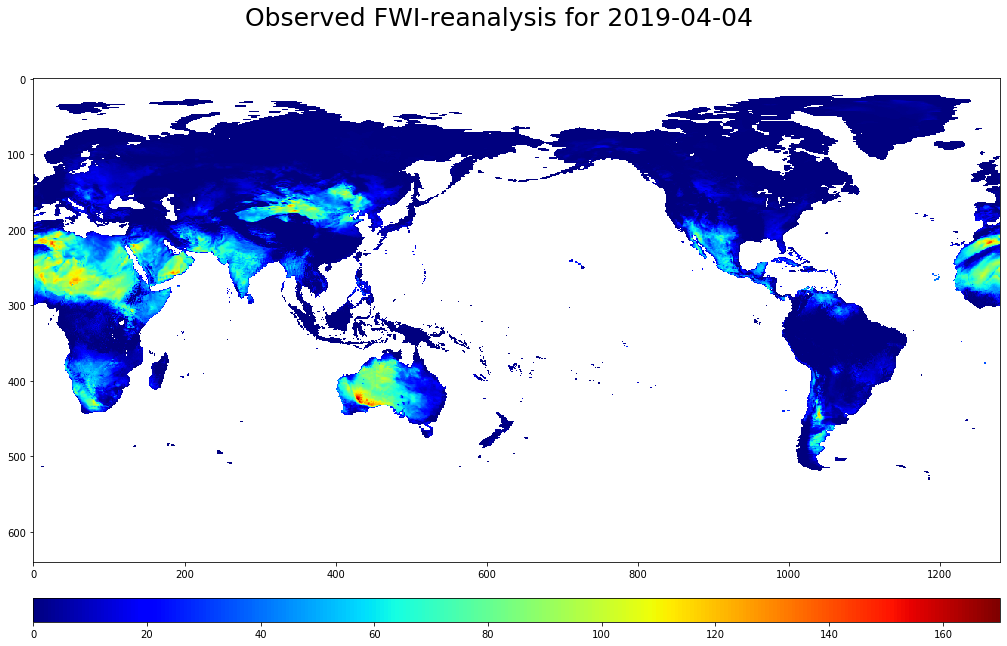

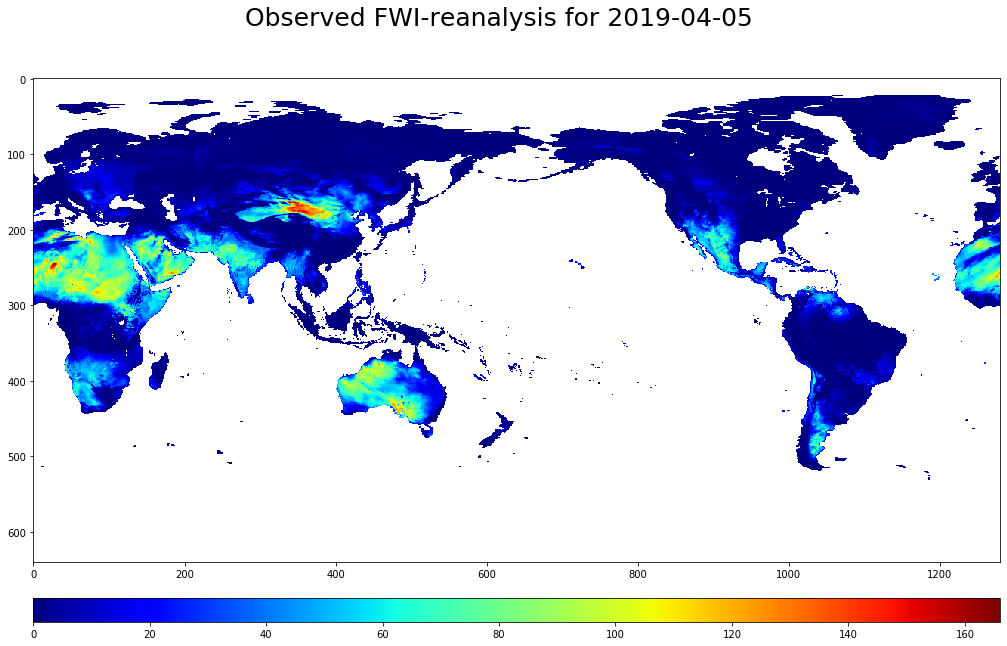

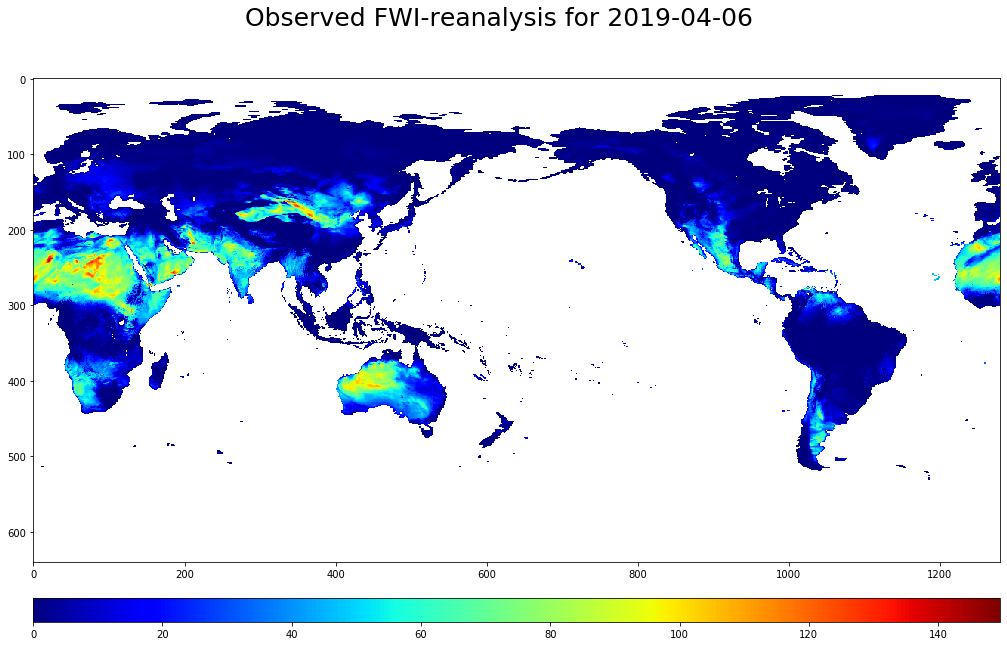

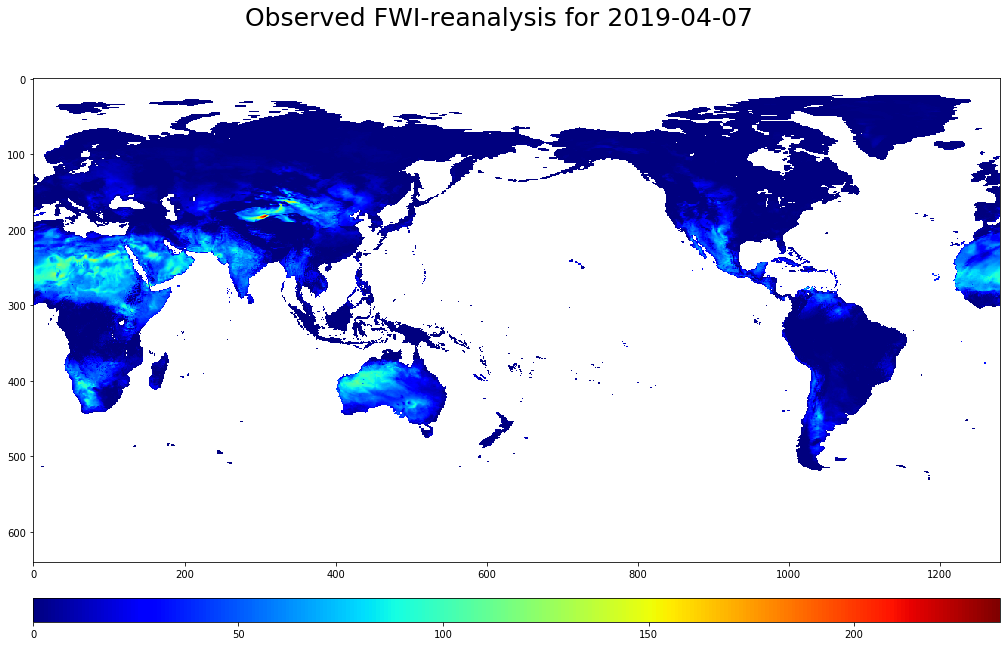

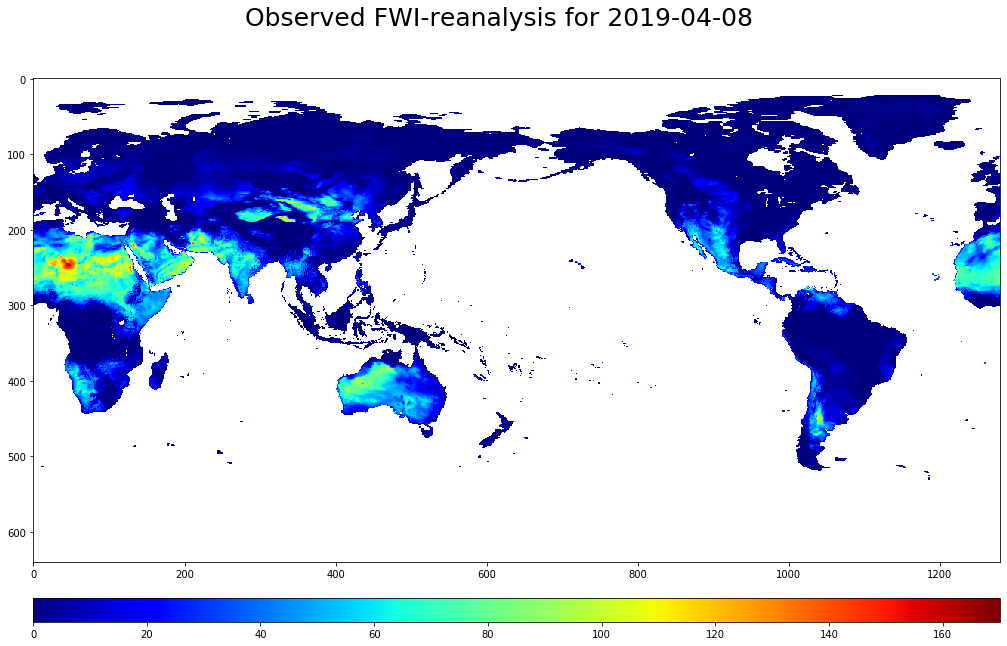

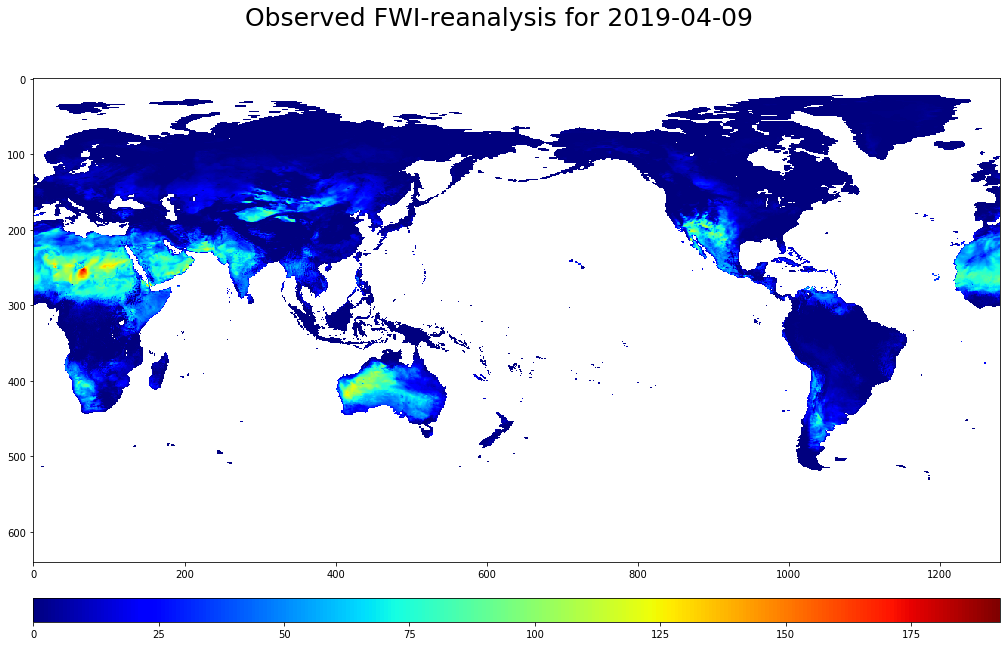

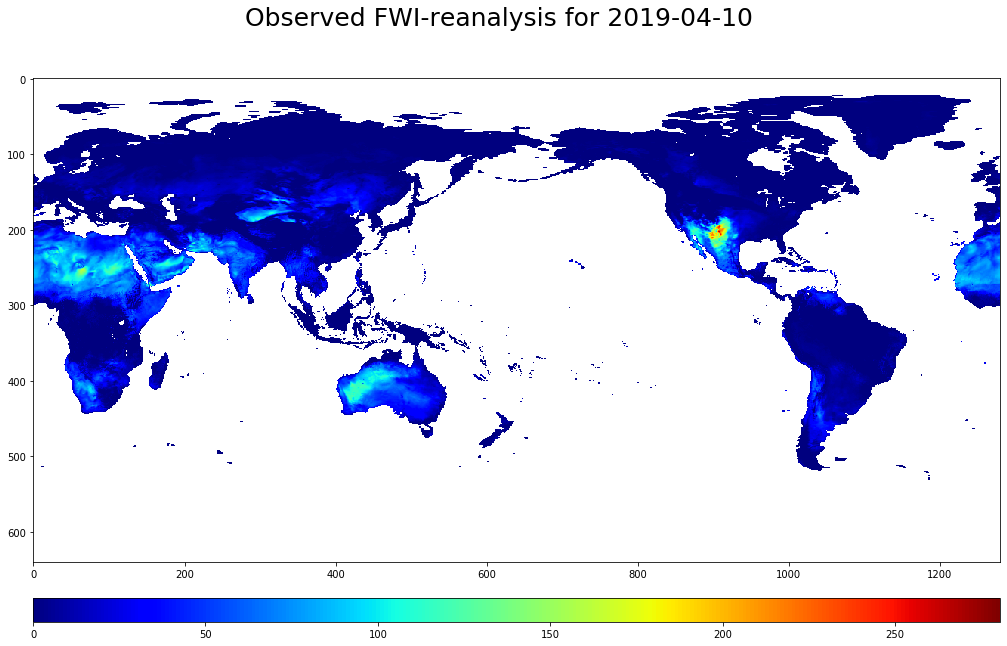

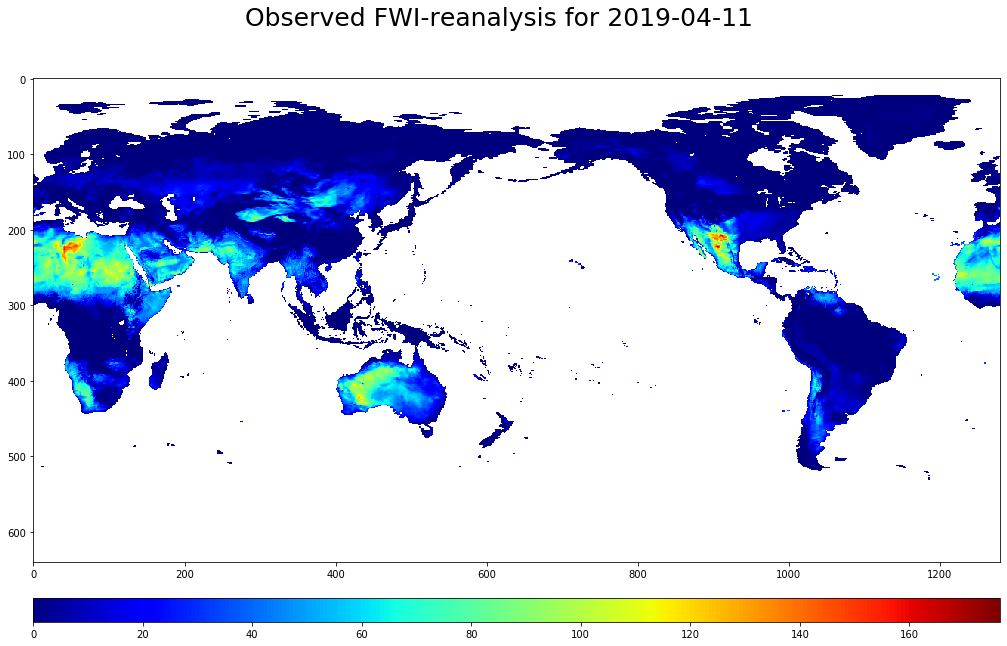

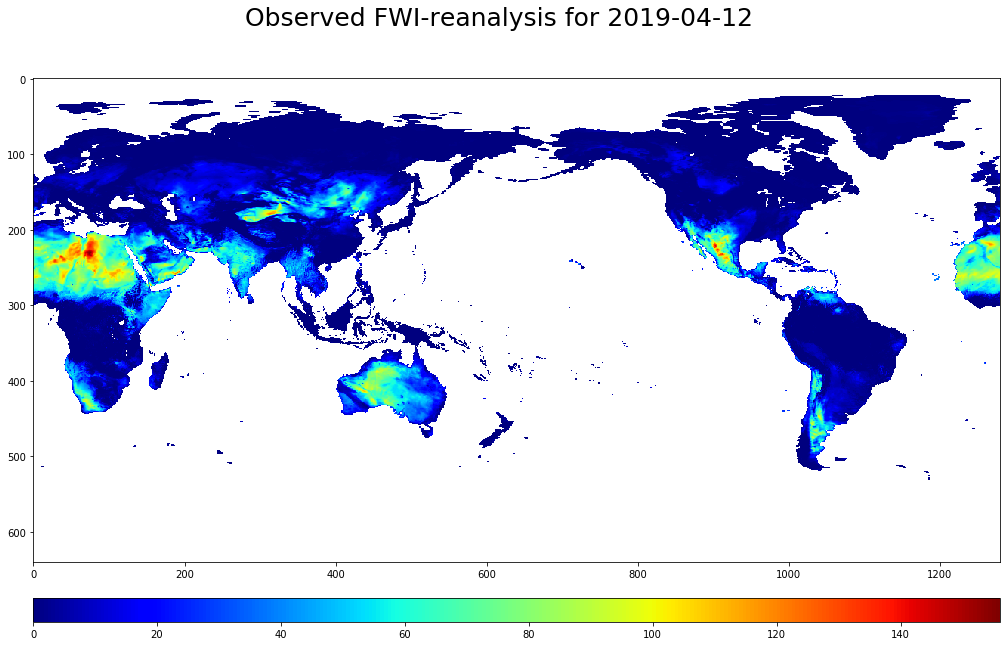

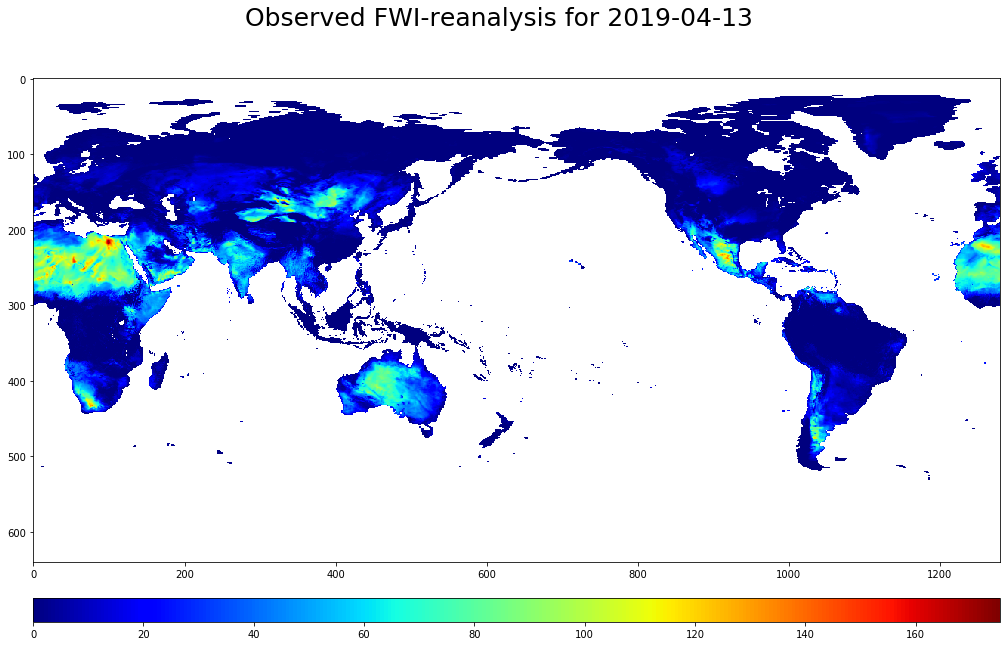

In [23]:
for i in range(hparams.out_days):
    plot(y.squeeze()[i], f'Observed FWI-reanalysis for 2019-04-{4+i:02}')
    plt.show()

#### Prediction

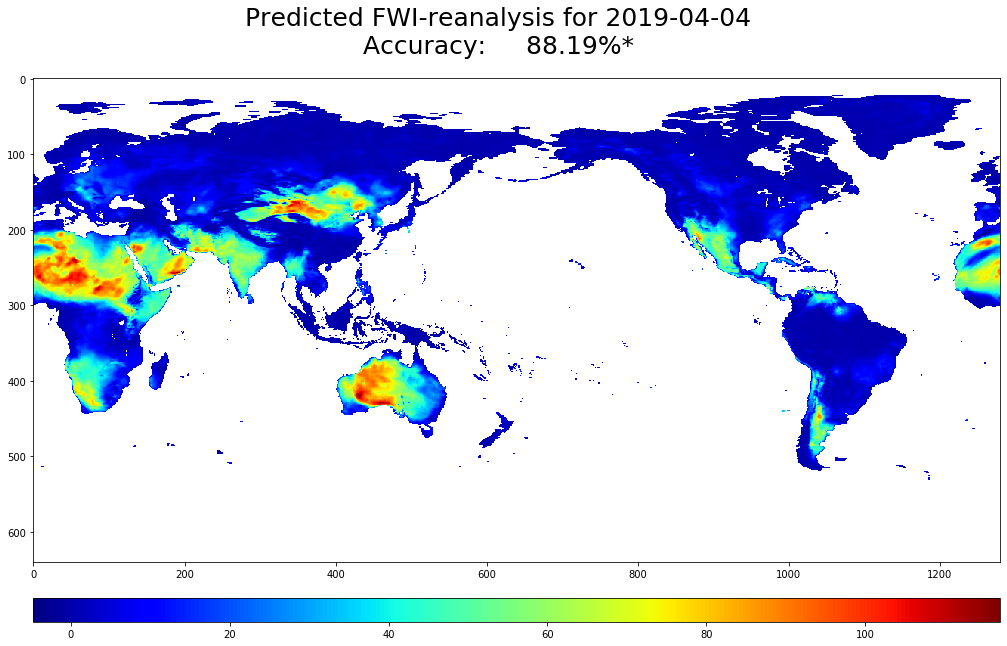

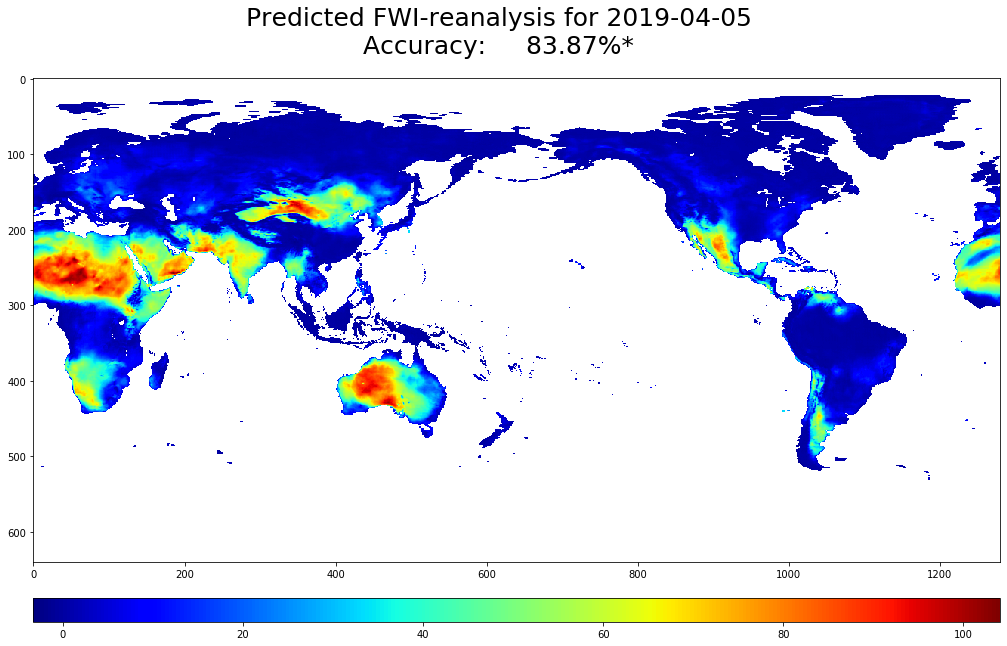

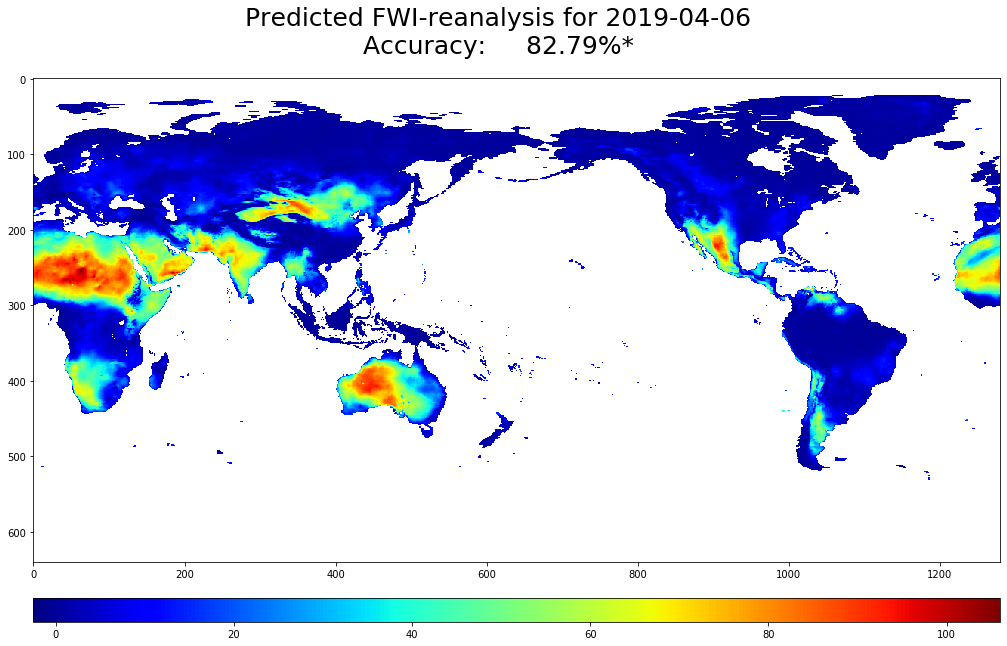

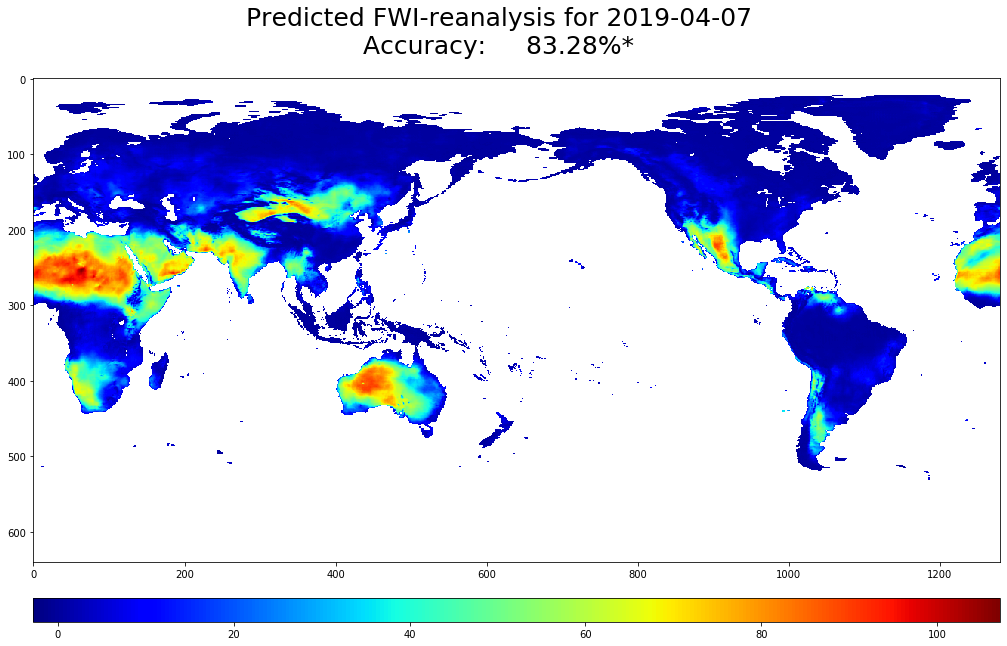

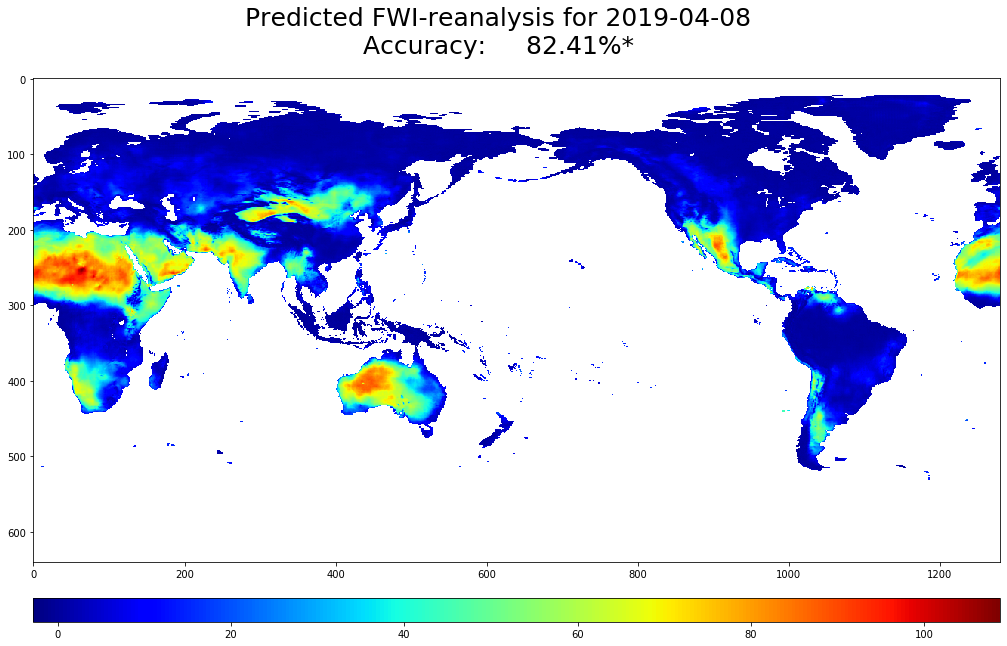

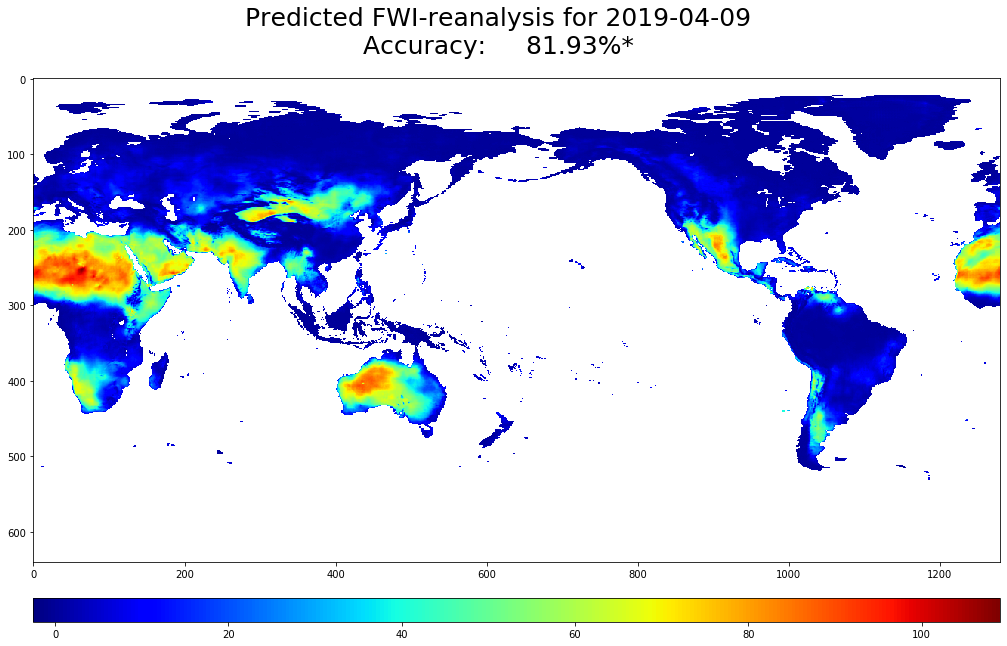

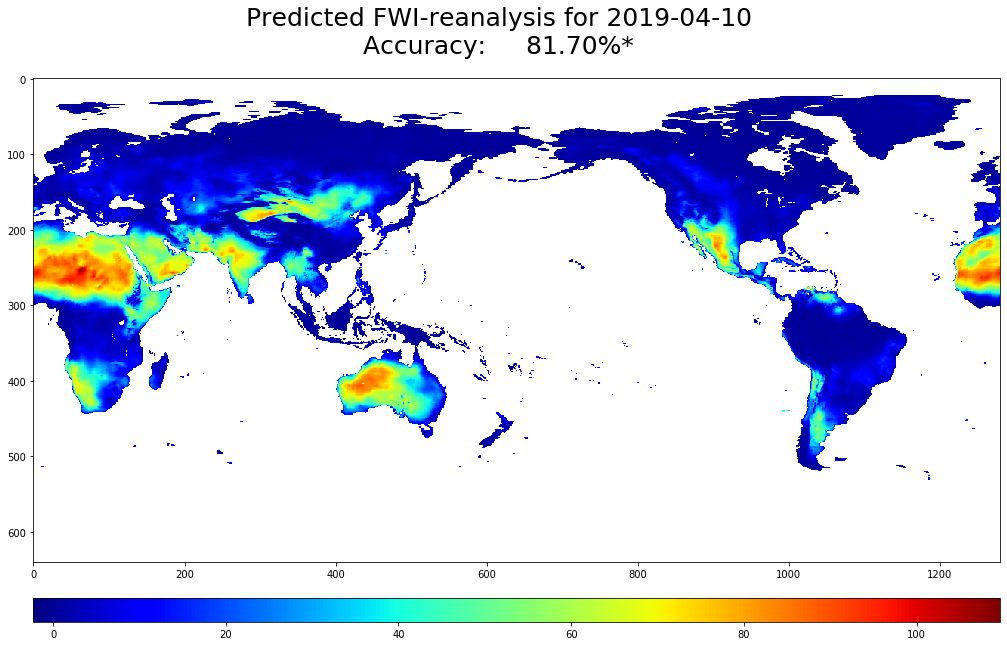

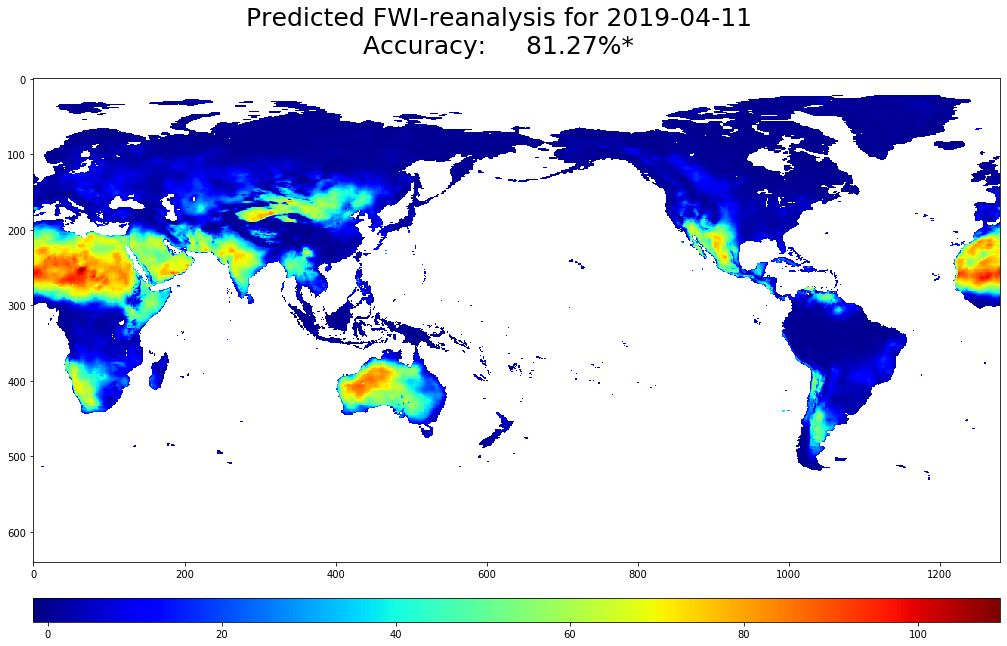

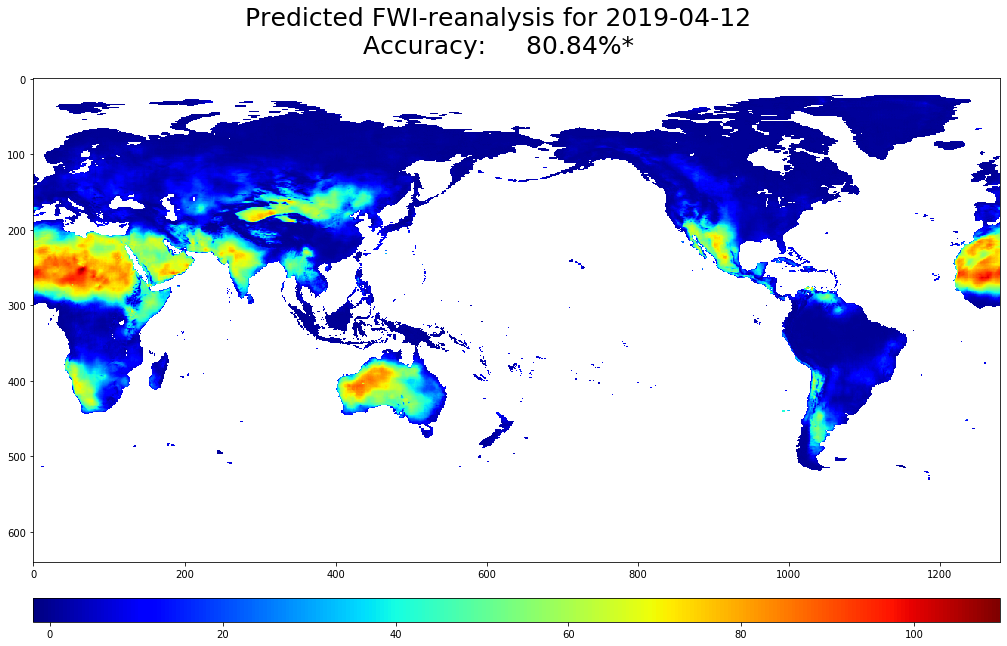

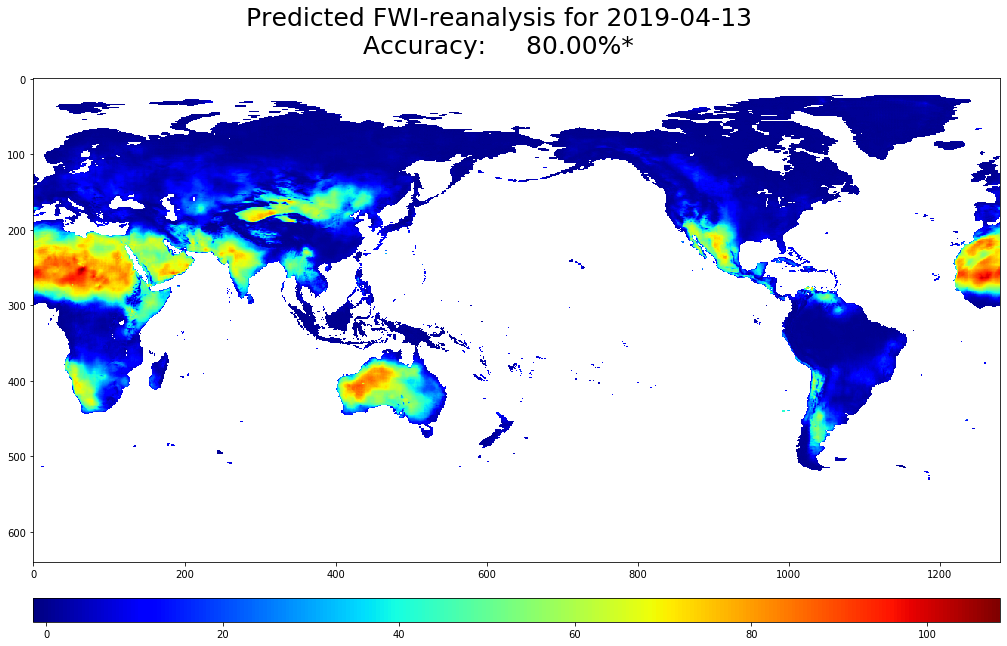

In [29]:
for i in range(hparams.out_days):
    plot(y_hat.squeeze()[i], f'Predicted FWI-reanalysis for 2019-04-{4+i:02}\nAccuracy: \
    {((y-y_hat).squeeze()[i].abs()<9.4)[model.data.mask].float().mean()*100:.2f}%*')
    plt.show()

<i>*Using half of MAD as the threshold

#### Prediction error

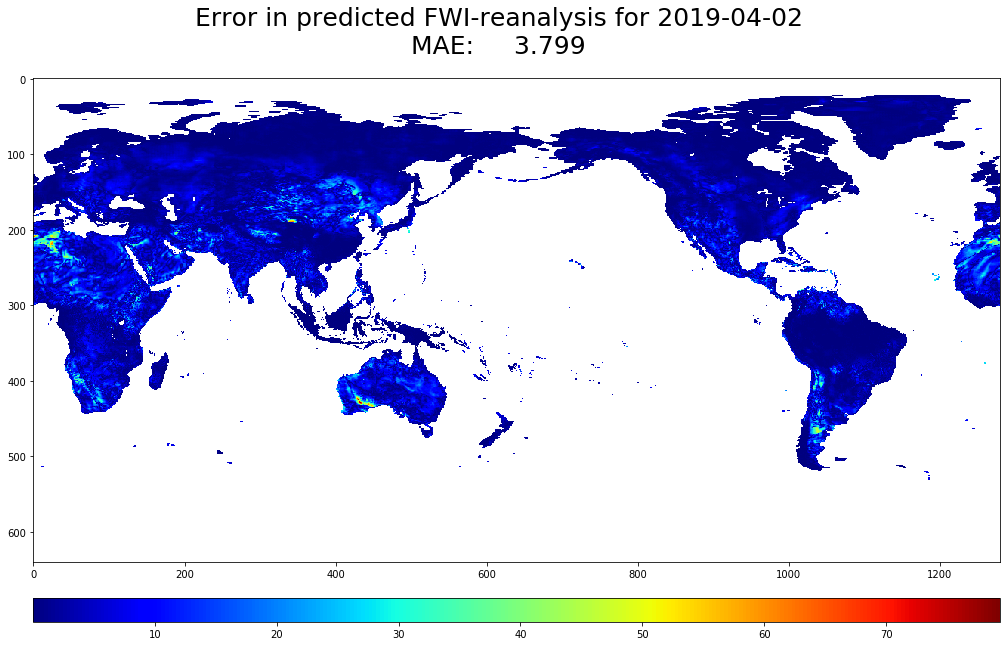

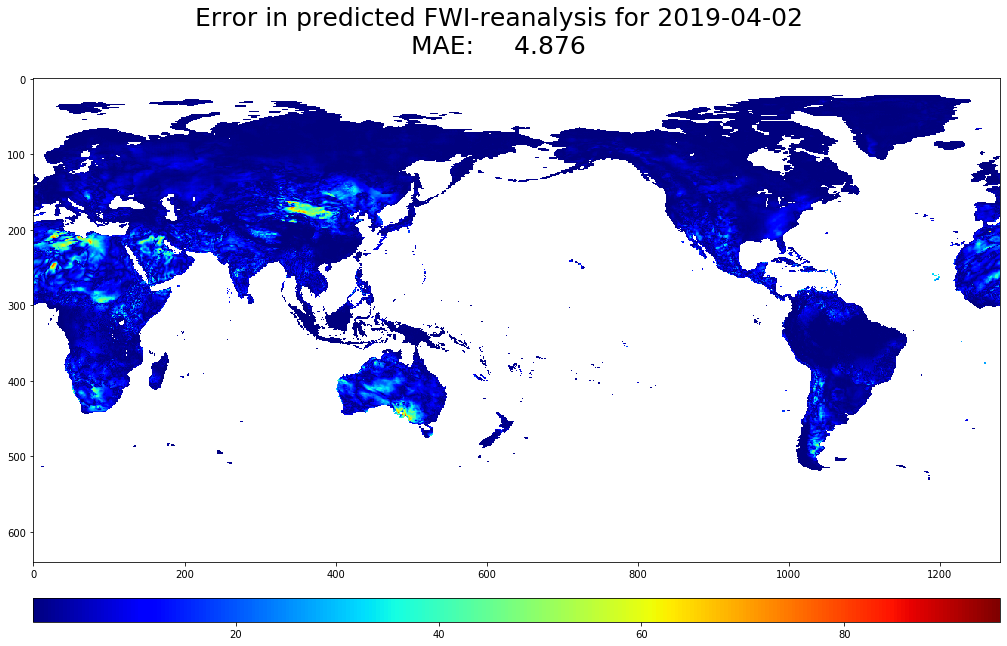

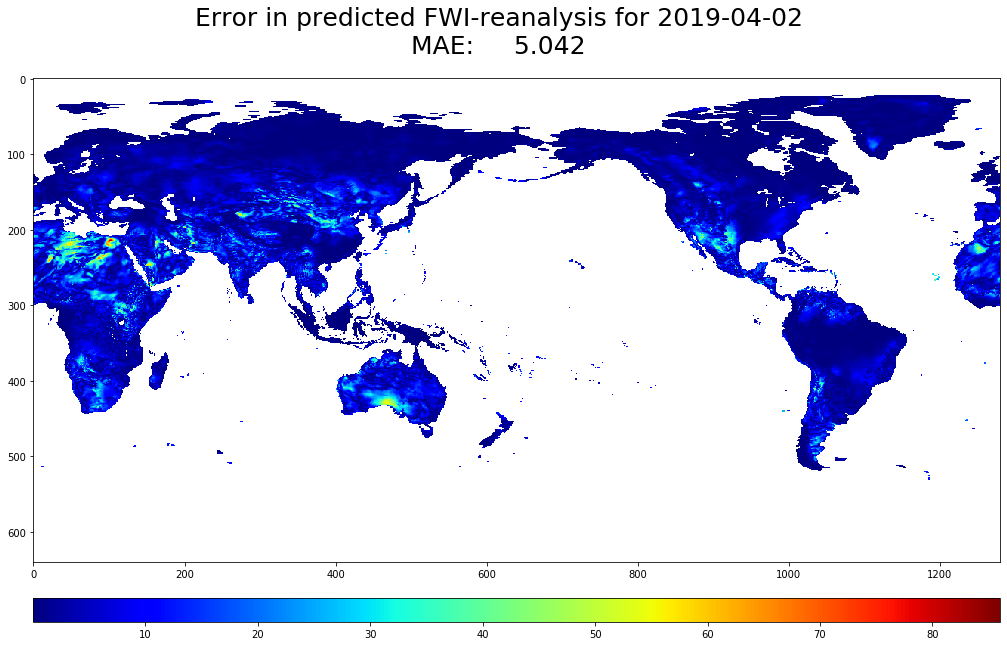

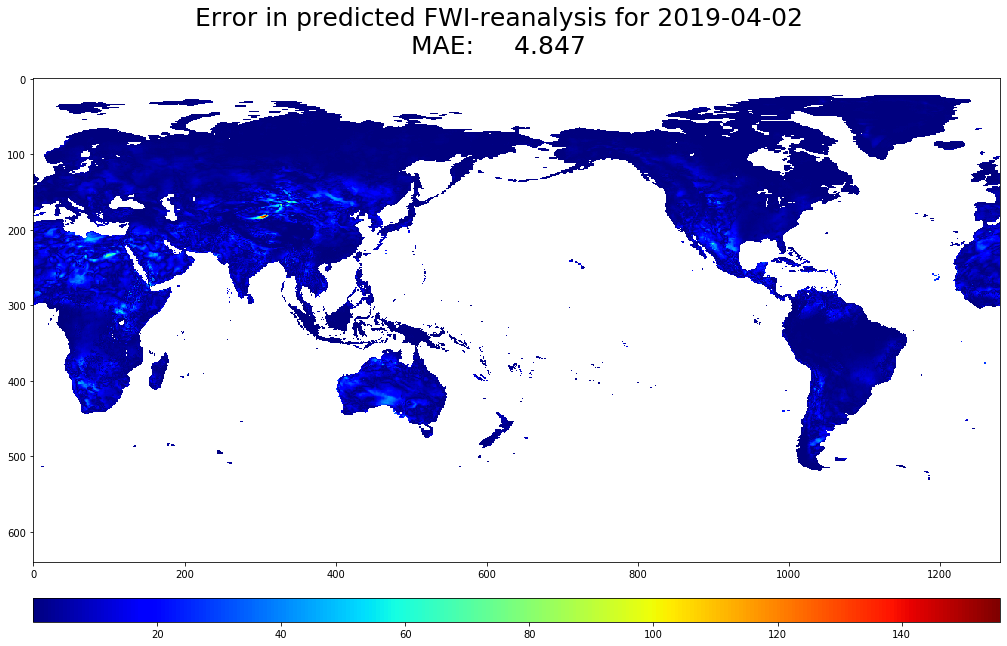

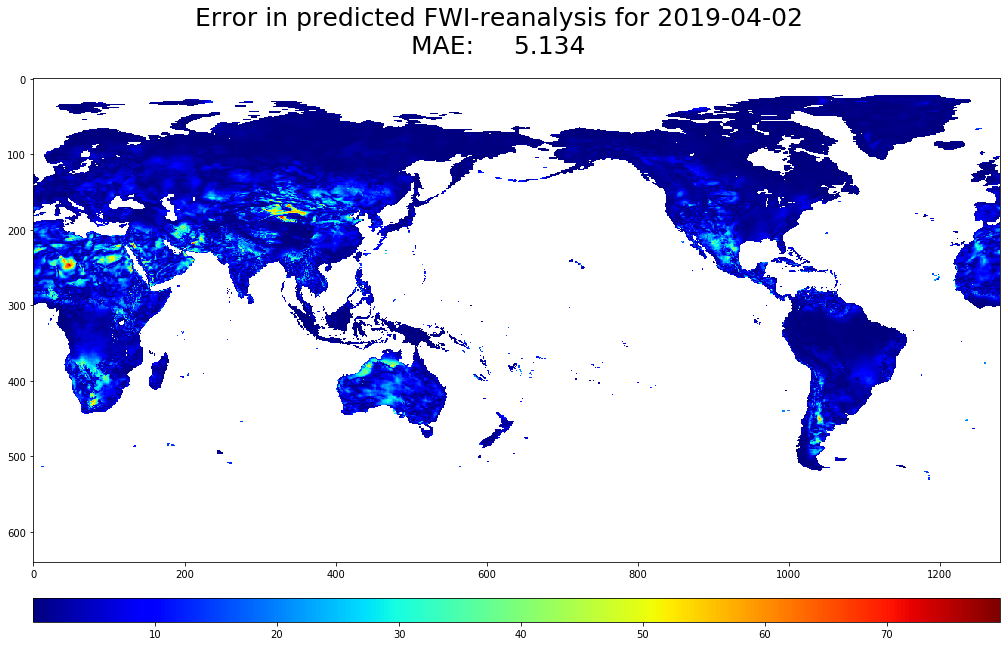

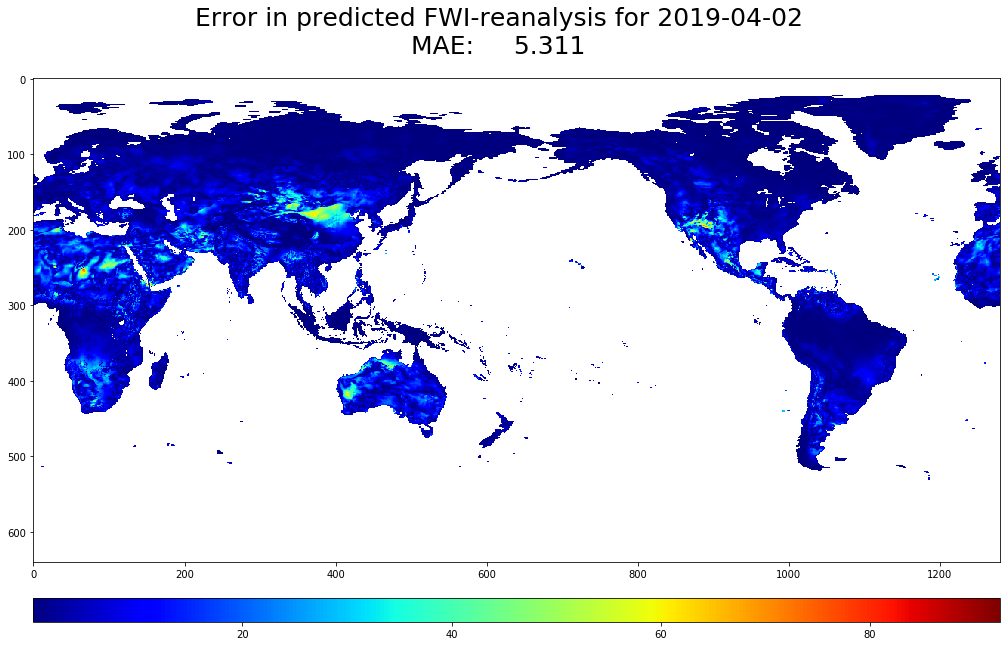

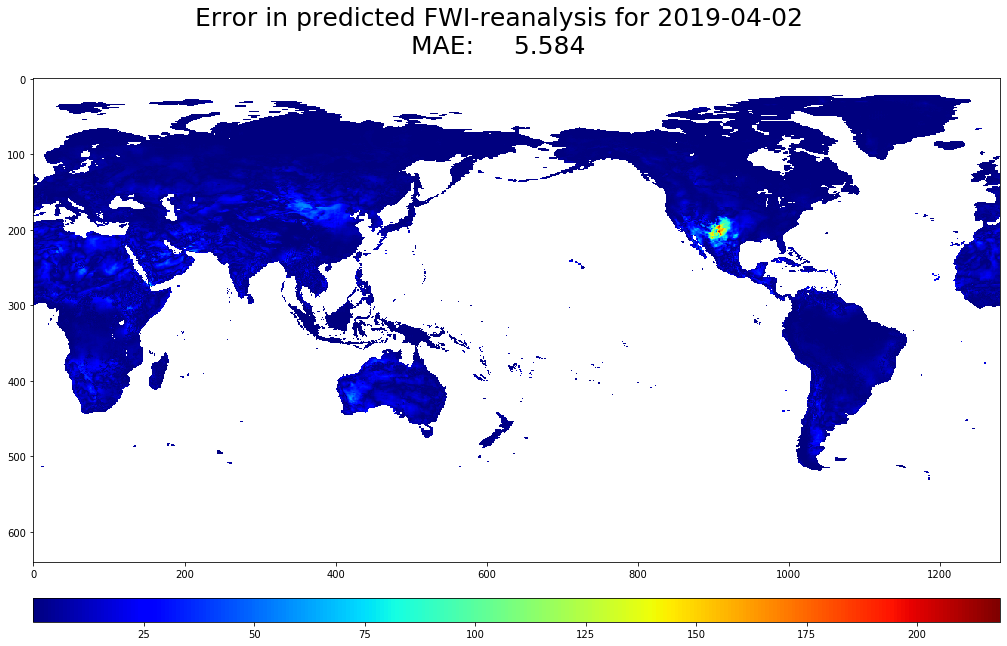

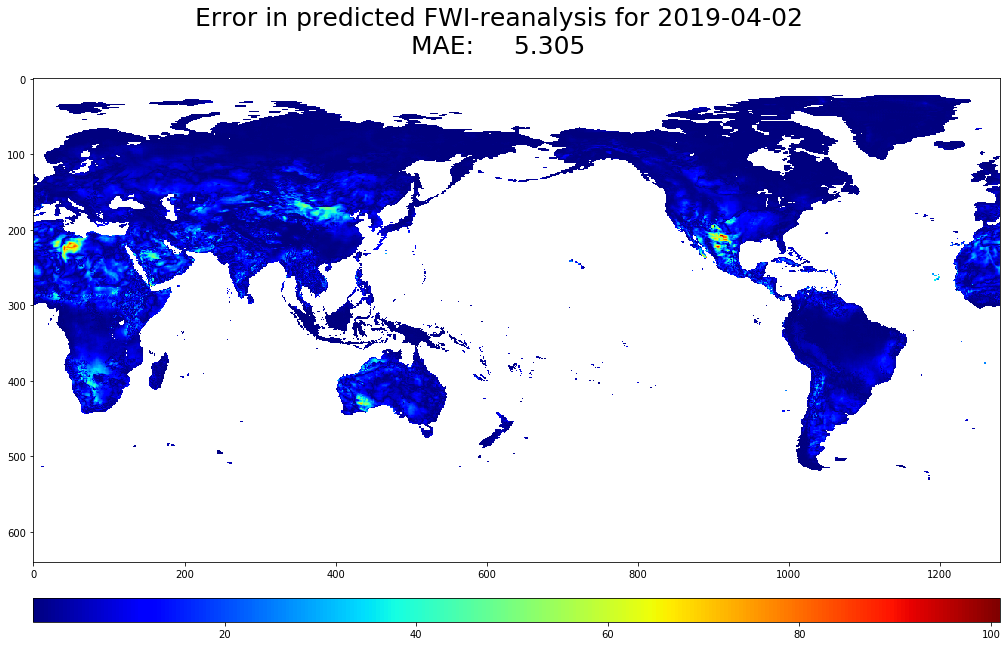

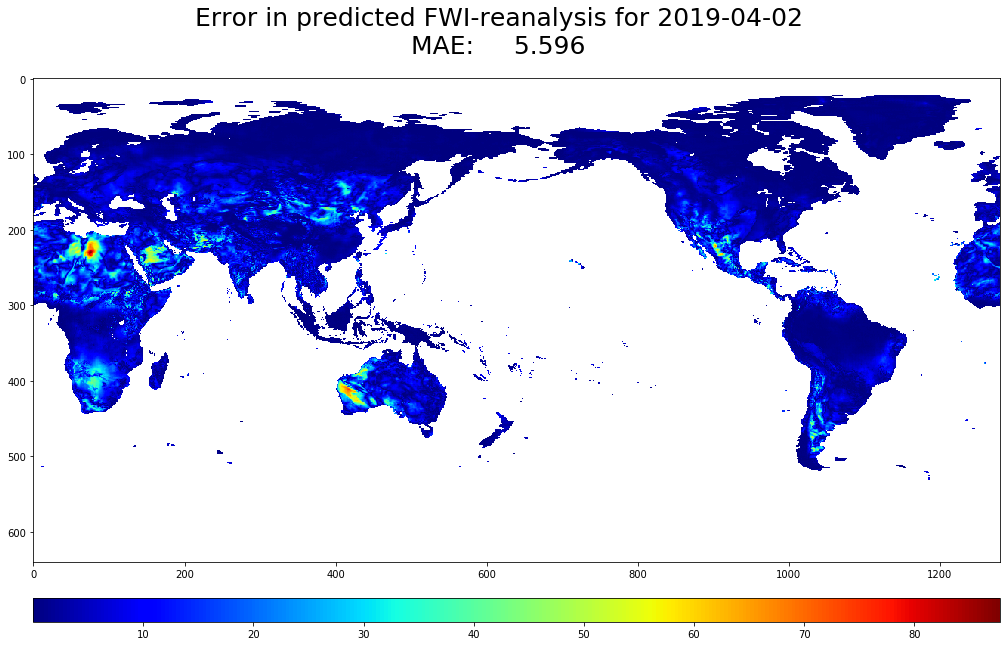

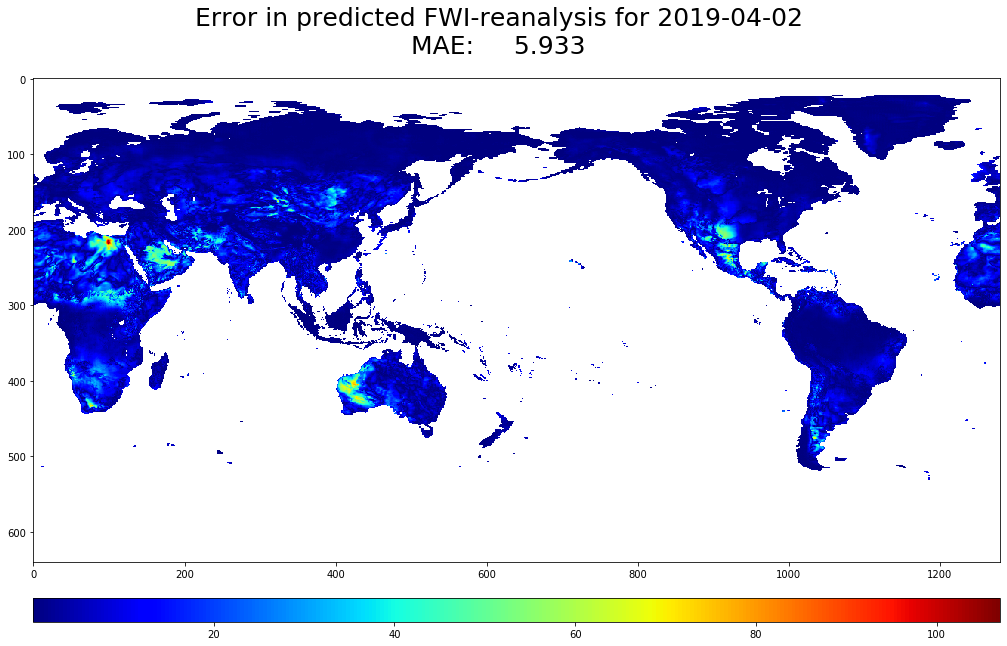

In [30]:
for i in range(hparams.out_days):
    plot((y-y_hat).abs().squeeze()[i], f"Error in predicted FWI-reanalysis for 2019-04-02\nMAE: \
    {((y-y_hat).squeeze()[i].abs())[model.data.mask].float().mean():.3f}")

### Bulk inference

Instead of passing inputs manually to the model, the Trainer can be used. It will run the prepared model over the entire data and generate the result metrics.

In [31]:
# Trainer object responsible for running the model
trainer = pl.Trainer(gpus=hparams.gpus)

# Running inference with the supplied model
trainer.test(model)

GPU available: True, used: True
No environment variable for node rank defined. Set as 0.
CUDA_VISIBLE_DEVICES: [0]
Test data loader called.


--------------------------------------------------------------------------------
TEST RESULTS
{'abs_error_0': tensor(3.7986, device='cuda:0'),
 'abs_error_1': tensor(4.8758, device='cuda:0'),
 'abs_error_2': tensor(5.0420, device='cuda:0'),
 'abs_error_3': tensor(4.8466, device='cuda:0'),
 'abs_error_4': tensor(5.1344, device='cuda:0'),
 'abs_error_5': tensor(5.3106, device='cuda:0'),
 'abs_error_6': tensor(5.5842, device='cuda:0'),
 'abs_error_7': tensor(5.3054, device='cuda:0'),
 'abs_error_8': tensor(5.5964, device='cuda:0'),
 'abs_error_9': tensor(5.9328, device='cuda:0'),
 'test_acc_0': tensor(0.8819, device='cuda:0'),
 'test_acc_1': tensor(0.8387, device='cuda:0'),
 'test_acc_2': tensor(0.8279, device='cuda:0'),
 'test_acc_3': tensor(0.8328, device='cuda:0'),
 'test_acc_4': tensor(0.8241, device='cuda:0'),
 'test_acc_5': tensor(0.8193, device='cuda:0'),
 'test_acc_6': tensor(0.8170, device='cuda:0'),
 'test_acc_7': tensor(0.8127, device='cuda:0'),
 'test_acc_8': tensor(0.8084, de

We did 10 days global forecast using 4-day input of Relative humidty, Temperature, Total precipitation, and Wind speed. We also looked at the error distribution of the prediction across the various regions and timescales.

| Day | MAE | Accuracy | MSE |
| :-: | :-: | :-: | :-: |
| 0 | 3.798 | 88.19% | 44.332 |
| 1 | 4.875 | 83.87% | 81.655 |
| 2 | 5.042 | 82.79% | 77.965 |
| 3 | 4.846 | 83.28% | 72.909 |
| 4 | 5.134 | 82.41% | 79.106 |
| 5 | 5.310 | 81.93% | 88.908 |
| 6 | 5.584 | 81.70% | 123.03 |
| 7 | 5.305 | 81.27% | 87.120 |
| 8 | 5.596 | 80.84% | 98.665 |
| 9 | 5.932 | 80.00% | 114.54 |